# Analysis for Figure2c

In [1]:
1

1

In [3]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["font.family"] = "DeJavu Serif"
plt.rcParams["font.serif"] = ["Times New Roman"]

In [4]:
import copy
import gc
import os
import sys
import warnings
import importlib
import subprocess
from pathlib import Path

import anndata as ad
import cupy as cp
import networkx as nx
import numpy as np
import pandas as pd
import rapids_singlecell as rsc
import scanpy as sc
import scib
import scib_metrics
import scipy.stats
import statsmodels.api as sm
import torch
from sklearn.neighbors import kneighbors_graph
from statsmodels.formula.api import ols

sys.path.append("/home/icb/kemal.inecik/work/codes/tardis")
import tardis

tardis.config = tardis.config_server

sc.settings.verbosity = 3

print(f"CUDA used: {torch.cuda.is_available()}")

/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/umap/__init__.py:9: ImportWarning: Tensorflow not installed; ParametricUMAP will be unavailable
  warn(
/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/lightning/fabric/plugins/environments/xla.py:18: DeprecationWarning: `ModuleAvailableCache` is a special case of `RequirementCache`. Please use `RequirementCache(module=...)` instead.
  from lightning.fabric.accelerators.tpu import _XLA_AVAILABLE, TPUAccelerator
/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/lightning/fabric/__init__.py:36: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('lightning.fabric')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  __import__("pkg_resources").declare_na

CUDA used: True


In [66]:
n_reserved_latent = 8
n_unreserved_latent = 24

dataset_handles = {
    "Kanemaru": {"models": {
        "scvi": 'kanemaru', 
        "tardis": {
            "kanemaru_sex_age_unit": {
                "targets": ["age", "sex", "integration_biological_unit"] # order is important
            }
        }, 
    }}, 
    "Braun": {"models": {
        "scvi": 'braun', 
        "tardis": {
            "braun_sex_age": {
                "targets": ["age", "sex"]  # order is important
            }
        }, 
    }},
    "Suo": {"models": {
        "scvi": 'suo', 
        "tardis": {
            "suo_age": {"targets": ["age"]},  # order is important
            "suo_sex": {"targets": ["sex"]},  # order is important
            "suo_organ": {"targets": ["organ"]},  # order is important
            "suo_platform": {"targets": ["platform"]},  # order is important
            "suo_sex_age_organ_platform": {"targets": ["age", "sex", "integration_library_platform_coarse", "organ"]},  # order is important
        }, 
    }},
    "Miller": {"models": {
        "scvi": 'miller', 
        "tardis": {
            "miller_age": {"targets": ["age"]}, # order is important
            "miller_sex": {"targets": ["sex"]}, # order is important
            "miller_sex_age": {"targets": ["age", "sex"]}, # order is important
        }, 
    }},
    "He": {"models": {
        "scvi": 'he', 
        "tardis": {
            "he_sex_age": {"targets": ["age", "sex"]} # order is important
        }, 
    }},
    "Garcia": {"models": {
        "scvi": 'garcia',
        "tardis": {
            "garcia_sex_age_status": {"targets": ["age", "sex", "integration_sample_status"]} # order is important
        }, 
        
    }},
}

In [67]:
args_list = []
k_neighbours = [15, 30]
for handle in dataset_handles:
    adata_dir = os.path.join(tardis.config.io_directories["processed"], f"dataset_complete_{handle}.h5ad")    
    for model_type in dataset_handles[handle]["models"]:
        if model_type == "scvi":
            model_name = dataset_handles[handle]["models"]["scvi"]
            model_dir = os.path.join(tardis.config.io_directories["models"], model_name)    
            for n_neighbors in k_neighbours:
                latent_dir = os.path.join(tardis.config.io_directories["temp"], "latent", f"{model_name}_{model_type}_{n_neighbors}_latent.h5ad")
                args_list.append([
                    adata_dir, model_dir, latent_dir, n_neighbors, model_name, "scvi"
                ])

        elif model_type == "tardis":
            for model_name in dataset_handles[handle]["models"]["tardis"]:
                model_dir = os.path.join(tardis.config.io_directories["models"], model_name)    
                for n_neighbors in k_neighbours:
                    latent_dir = os.path.join(tardis.config.io_directories["temp"], "latent", f"{model_name}_{model_type}_{n_neighbors}_latent.h5ad")
                    args_list.append([
                        adata_dir, model_dir, latent_dir, n_neighbors, model_name, "tardis"
                    ])
                dataset_handles[handle]["models"]["tardis"][model_name]["reserved"] = {
                    i: list(range(8 * ind, 8 * (ind+1))) for ind, i in enumerate(dataset_handles[handle]["models"]["tardis"][model_name]["targets"])
                }

In [68]:
dataset_handles

{'Kanemaru': {'models': {'scvi': 'kanemaru',
   'tardis': {'kanemaru_sex_age_unit': {'targets': ['age',
      'sex',
      'integration_biological_unit'],
     'reserved': {'age': [0, 1, 2, 3, 4, 5, 6, 7],
      'sex': [8, 9, 10, 11, 12, 13, 14, 15],
      'integration_biological_unit': [16, 17, 18, 19, 20, 21, 22, 23]}}}}},
 'Braun': {'models': {'scvi': 'braun',
   'tardis': {'braun_sex_age': {'targets': ['age', 'sex'],
     'reserved': {'age': [0, 1, 2, 3, 4, 5, 6, 7],
      'sex': [8, 9, 10, 11, 12, 13, 14, 15]}}}}},
 'Suo': {'models': {'scvi': 'suo',
   'tardis': {'suo_age': {'targets': ['age'],
     'reserved': {'age': [0, 1, 2, 3, 4, 5, 6, 7]}},
    'suo_sex': {'targets': ['sex'],
     'reserved': {'sex': [0, 1, 2, 3, 4, 5, 6, 7]}},
    'suo_organ': {'targets': ['organ'],
     'reserved': {'organ': [0, 1, 2, 3, 4, 5, 6, 7]}},
    'suo_platform': {'targets': ['platform'],
     'reserved': {'platform': [0, 1, 2, 3, 4, 5, 6, 7]}},
    'suo_sex_age_organ_platform': {'targets': ['age'

In [40]:
for args in args_list:
    data_dir, model_dir, output_dir, n_neighbors, model_name, model_type = args
    print(model_type, model_name, n_neighbors)

    # Check if output directory does not exist and model directory does exist
    if os.path.exists(output_dir):
        print(f"Latent is calculated already: `{model_name, n_neighbors}`")
    
    elif not os.path.exists(model_dir):
        print(f"Model is not there: `{model_name}`")
    
    elif not os.path.exists(output_dir) and os.path.exists(model_dir):
        # Generate the Slurm script
        slurm_script = f"""#!/bin/bash

#SBATCH -J tardis_latent_run
#SBATCH -p gpu_p
#SBATCH --qos=gpu_normal
#SBATCH --gres=gpu:1
#SBATCH -c 6
#SBATCH --mem=159G
#SBATCH --nice=0
#SBATCH -t 1-23:50:00

source activate tardis_env
python /home/icb/kemal.inecik/work/codes/tardis/notebooks/figure2c/collect_latent.py {data_dir} {model_dir} {output_dir} {n_neighbors}
"""

        # Save the script to a temporary file
        script_file = os.path.join(os.getcwd(), f"slurm_job_{model_name}_{n_neighbors}.sh")
        with open(script_file, "w") as file:
            file.write(slurm_script)

        # Submit the Slurm job
        subprocess.run(["sbatch", script_file])
        subprocess.run(["rm", "-rf", script_file])
    else:
        raise ValueError

scvi kanemaru 15
Submitted batch job 20173865
scvi kanemaru 30
Submitted batch job 20173866
tardis kanemaru_sex_age_unit 15
Submitted batch job 20173867
tardis kanemaru_sex_age_unit 30
Submitted batch job 20173868
scvi braun 15
Submitted batch job 20173869
scvi braun 30
Submitted batch job 20173870
tardis braun_sex_age 15
Submitted batch job 20173871
tardis braun_sex_age 30
Submitted batch job 20173872
scvi suo 15
Submitted batch job 20173873
scvi suo 30
Submitted batch job 20173874
tardis suo_age 15
Model is not there: `suo_age`
tardis suo_age 30
Model is not there: `suo_age`
tardis suo_sex 15
Model is not there: `suo_sex`
tardis suo_sex 30
Model is not there: `suo_sex`
tardis suo_organ 15
Model is not there: `suo_organ`
tardis suo_organ 30
Model is not there: `suo_organ`
tardis suo_platform 15
Model is not there: `suo_platform`
tardis suo_platform 30
Model is not there: `suo_platform`
tardis suo_sex_age_organ_platform 15
Model is not there: `suo_sex_age_organ_platform`
tardis suo_sex

In [41]:
for i in args_list:
    print(os.path.split(i[2])[1])

kanemaru_scvi_15_latent.h5ad
kanemaru_scvi_30_latent.h5ad
kanemaru_sex_age_unit_tardis_15_latent.h5ad
kanemaru_sex_age_unit_tardis_30_latent.h5ad
braun_scvi_15_latent.h5ad
braun_scvi_30_latent.h5ad
braun_sex_age_tardis_15_latent.h5ad
braun_sex_age_tardis_30_latent.h5ad
suo_scvi_15_latent.h5ad
suo_scvi_30_latent.h5ad
suo_age_tardis_15_latent.h5ad
suo_age_tardis_30_latent.h5ad
suo_sex_tardis_15_latent.h5ad
suo_sex_tardis_30_latent.h5ad
suo_organ_tardis_15_latent.h5ad
suo_organ_tardis_30_latent.h5ad
suo_platform_tardis_15_latent.h5ad
suo_platform_tardis_30_latent.h5ad
suo_sex_age_organ_platform_tardis_15_latent.h5ad
suo_sex_age_organ_platform_tardis_30_latent.h5ad
miller_scvi_15_latent.h5ad
miller_scvi_30_latent.h5ad
miller_age_tardis_15_latent.h5ad
miller_age_tardis_30_latent.h5ad
miller_sex_tardis_15_latent.h5ad
miller_sex_tardis_30_latent.h5ad
miller_sex_age_tardis_15_latent.h5ad
miller_sex_age_tardis_30_latent.h5ad
he_scvi_15_latent.h5ad
he_scvi_30_latent.h5ad
he_sex_age_tardis_15_lat

In [69]:
!ls -lh /lustre/groups/ml01/workspace/kemal.inecik/tardis_data/temp/latent

total 2.2G
-rw-r--r--. 1 kemal.inecik OG-ICB-User 111M Apr 23 23:15 garcia_scvi_15_latent.h5ad
-rw-r--r--. 1 kemal.inecik OG-ICB-User 180M Apr 23 23:15 garcia_scvi_30_latent.h5ad
-rw-r--r--. 1 kemal.inecik OG-ICB-User 127M Apr 23 23:15 garcia_sex_age_status_tardis_15_latent.h5ad
-rw-r--r--. 1 kemal.inecik OG-ICB-User 192M Apr 23 23:15 garcia_sex_age_status_tardis_30_latent.h5ad
-rw-r--r--. 1 kemal.inecik OG-ICB-User  35M Apr 23 23:12 he_scvi_15_latent.h5ad
-rw-r--r--. 1 kemal.inecik OG-ICB-User  55M Apr 23 23:12 he_scvi_30_latent.h5ad
-rw-r--r--. 1 kemal.inecik OG-ICB-User  39M Apr 23 23:12 he_sex_age_tardis_15_latent.h5ad
-rw-r--r--. 1 kemal.inecik OG-ICB-User  59M Apr 23 23:12 he_sex_age_tardis_30_latent.h5ad
-rw-r--r--. 1 kemal.inecik OG-ICB-User  68M Apr 23 23:11 kanemaru_scvi_15_latent.h5ad
-rw-r--r--. 1 kemal.inecik OG-ICB-User 108M Apr 23 23:11 kanemaru_scvi_30_latent.h5ad
-rw-r--r--. 1 kemal.inecik OG-ICB-User  79M Apr 23 23:11 kanemaru_sex_age_unit_tardis_15_latent.h5ad
-rw-r-

In [58]:
for i in args_list:
    if os.path.split(i[2])[1].startswith("kanemaru"):
        print(i[2])

/lustre/groups/ml01/workspace/kemal.inecik/tardis_data/temp/latent/kanemaru_scvi_15_latent.h5ad
/lustre/groups/ml01/workspace/kemal.inecik/tardis_data/temp/latent/kanemaru_scvi_30_latent.h5ad
/lustre/groups/ml01/workspace/kemal.inecik/tardis_data/temp/latent/kanemaru_sex_age_unit_tardis_15_latent.h5ad
/lustre/groups/ml01/workspace/kemal.inecik/tardis_data/temp/latent/kanemaru_sex_age_unit_tardis_30_latent.h5ad


(841922, 24)
{'elbo': -403.5125732421875, 'r2_train': 0.9872151846327756, 'r2_train_deg_20': 0.9935874054112811, 'r2_train_deg_50': 0.9904303515483265, 'r2_validation': 0.9866543840076373, 'r2_validation_deg_20': 0.9895062419525495, 'r2_validation_deg_50': 0.9906673218586487, 'reconstruction_error': -390.78149497518774}


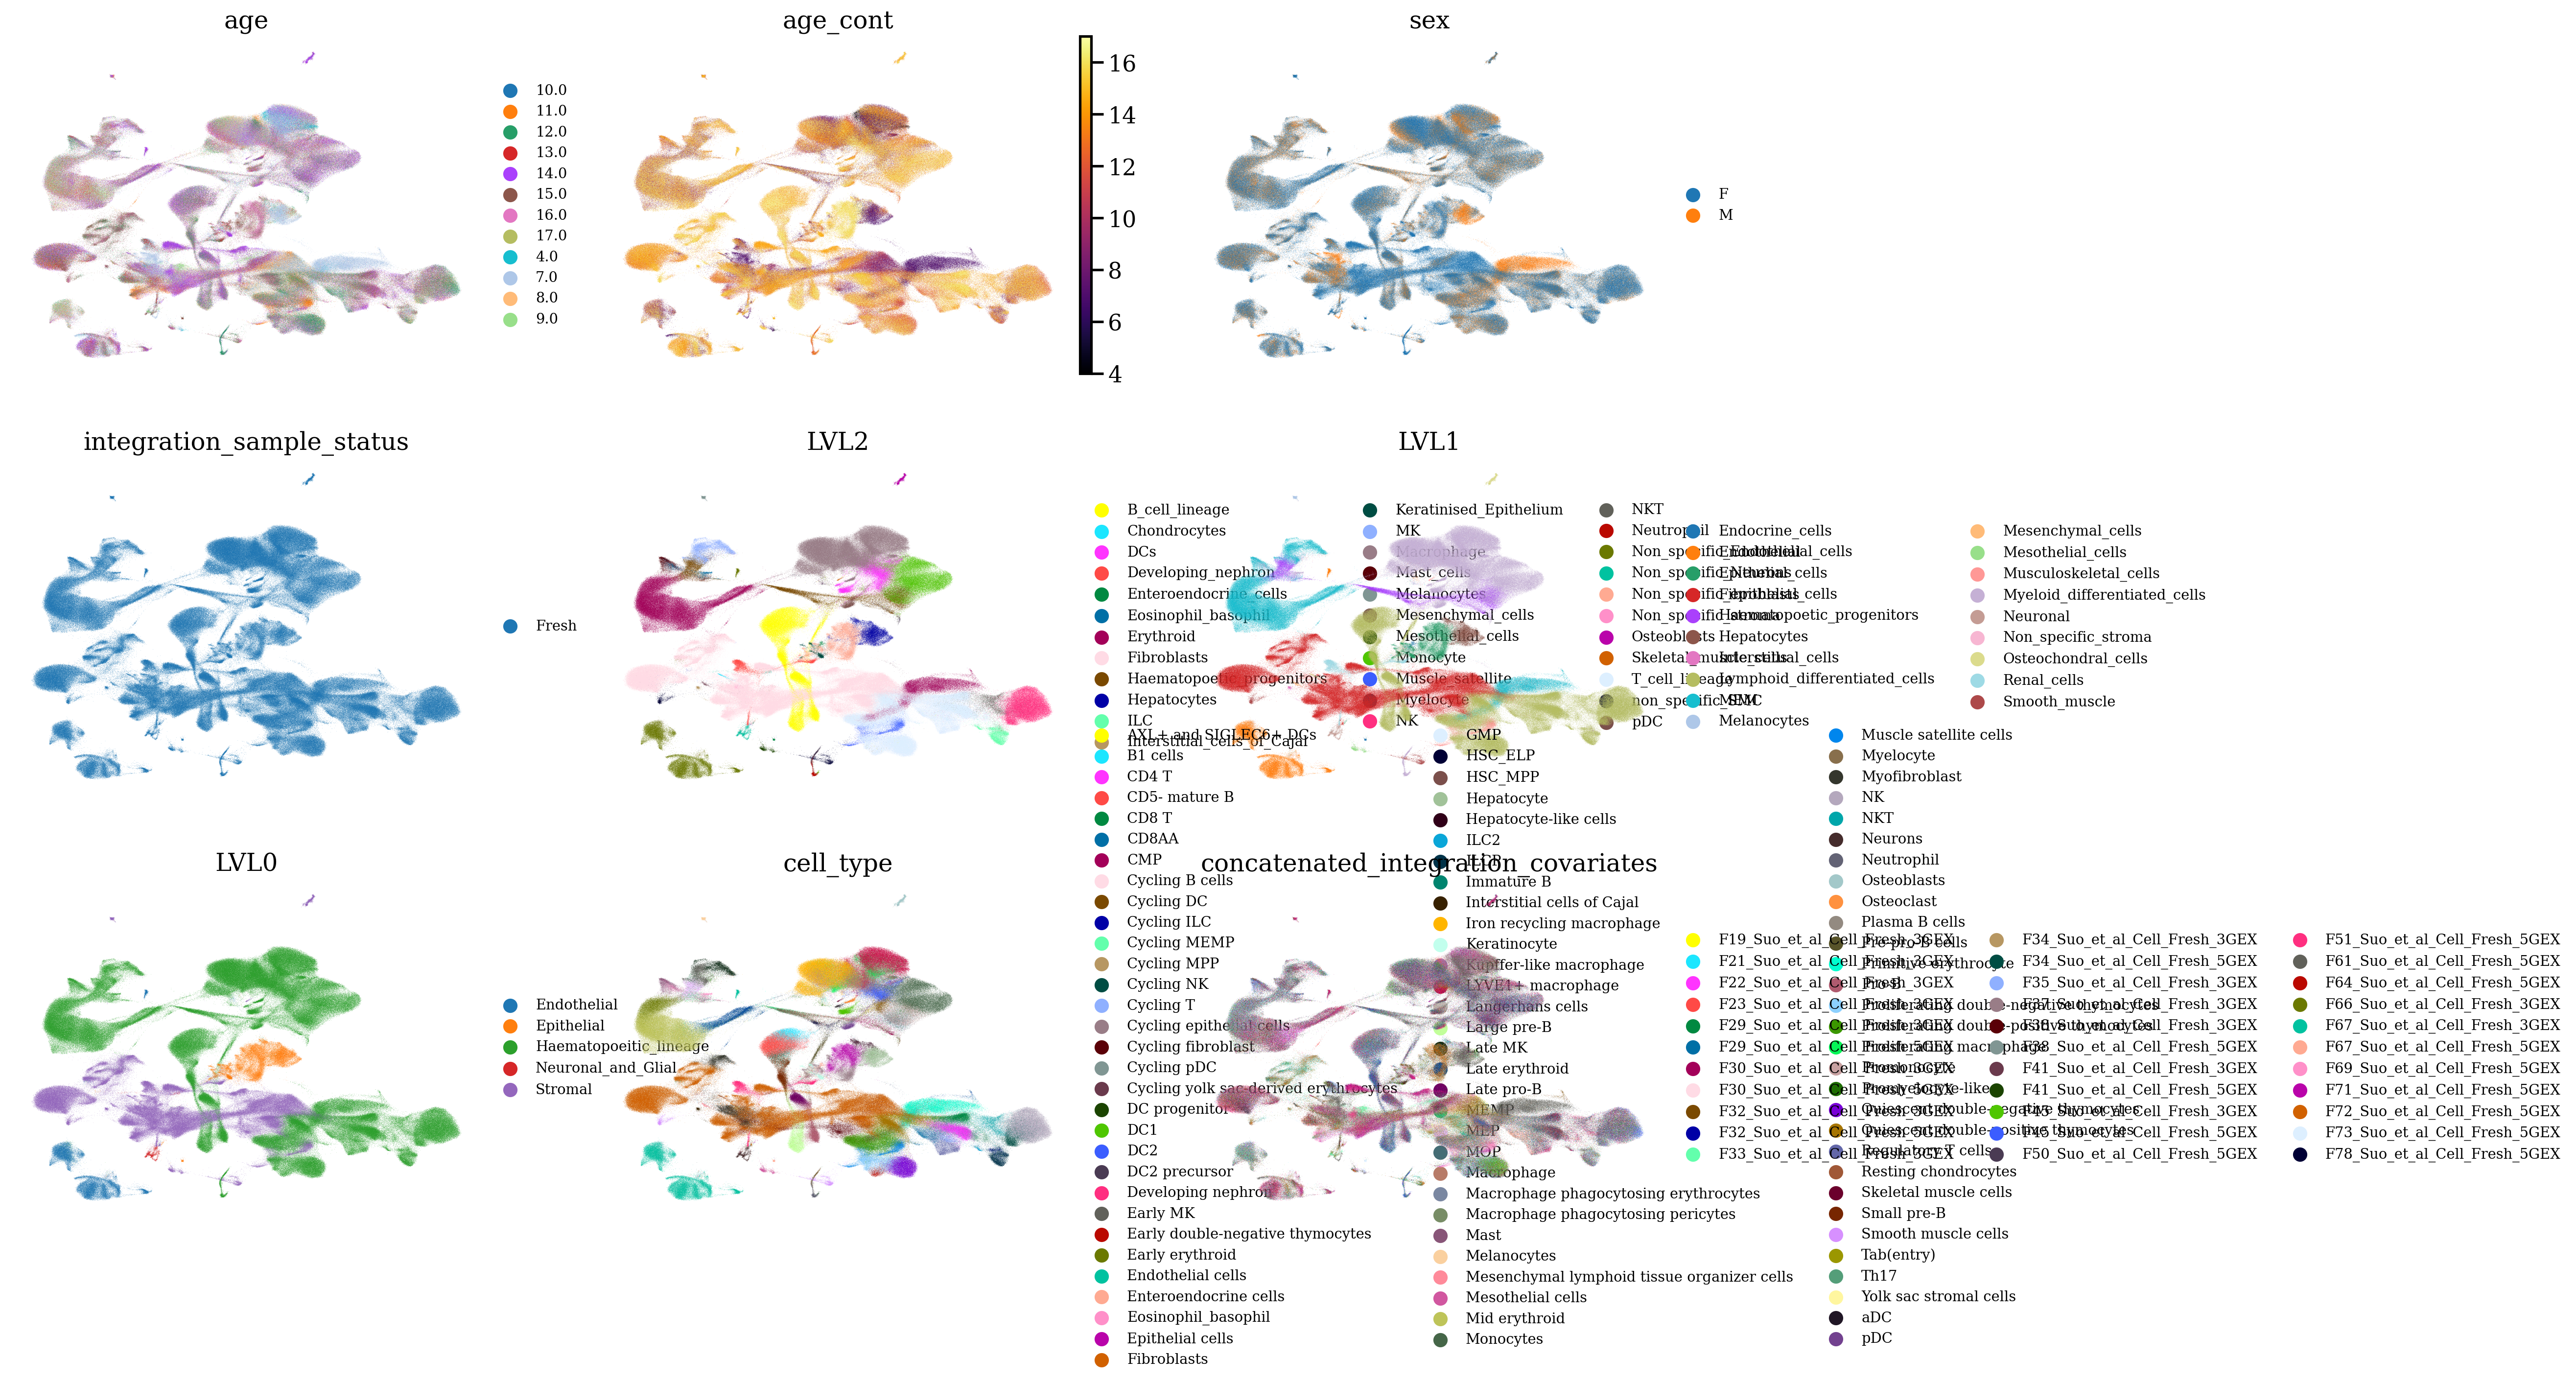

In [71]:
latent = ad.read_h5ad("/lustre/groups/ml01/workspace/kemal.inecik/tardis_data/temp/latent/suo_scvi_30_latent.h5ad")
print(latent.shape)
print(latent.uns["metrics"])
latent.obs["age_cont"] = latent.obs["age"].astype(float)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent,
        color=[
            "age",
            "age_cont",
            "sex",
            "integration_sample_status",
            "LVL2",
            "LVL1",
            "LVL0",
            "cell_type",
            "concatenated_integration_covariates",
        ],
        ncols=3,
        color_map="inferno",
        frameon=False,
        legend_fontsize="xx-small",
        show=False,
    )
    plt.show()
    del latent
    gc.collect()